In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OrdinalEncoder, KBinsDiscretizer

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from collections import Counter


from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

np.random.seed(0)
import matplotlib.pyplot as plt

import seaborn as sns; sns.set_theme()

In [2]:
def display_summary(true,pred):
    tn, fp, fn, tp = confusion_matrix(true,pred).ravel()
    precision = tp/(tp+fp)
    sensitivity = tp/(tp+fn)
    balanced_accuracy = 1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp))
    Fscore = 2.*(precision*sensitivity)/(precision+sensitivity)
    print('confusion matrix')
    print(np.array([[tp,fp],[fn,tn]]))
    print('sensitivity is %f',1.*tp/(tp+fn))
    print('specificity is %f',1.*tn/(tn+fp))
    print('accuracy is %f',1.*(tp+tn)/(tp+tn+fp+fn))
    print('balanced accuracy is %',1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp)))
    print('F-score is %', Fscore)
    return Fscore, balanced_accuracy

## Tabla de Contenidos
* [Objetivo de este Notebook](#Objetivos)
* [Análsis del dataset](#Analysis)
* [Implementación del modelo](#Model)
    * [Aproach 1](#model1)
    * [Aproach 2](#model2)
    * [Aproach 3](#model3)
    * [Aproach 4](#model4)
    * [Resultados](#results)
        * [Ejemplo](#ejemploClasificacion)
* [Conclusiones](#Model)
* [Referencias](#segmentacion)

<a id = 'Objetivos'></a>
### <font color = "darkblue">El Objetivo de este notebook</font>
Presentar la solución al Data Scientist Challenge de Rappi, en donde se busca 



<a id = 'Analysis'></a>
# <font color = "darkblue">Análsis del dataset</font>

En esta sección del notebook se busca entender la información que se encuentra en el dataset; cómo está consituido, que variables contiene, que variables son categoricas y cuáles son númericas, etc. Para se ello se realizan las siguientes procedimientos:
- Análisis estadisticos
- Distribuciones de variables continúas
- Correlaciones de variables
- Características de trasaccciones fradulentas y características de personas que comenten fraude


Como primer paso se carga el dataset y se analiza las variables que contiene:

In [8]:
df = pd.read_csv('ds_challenge_2021.csv')
df['dispositivo']=df['dispositivo'].apply(lambda x:eval(x))
df = pd.concat([df, pd.json_normalize(df["dispositivo"])], axis=1)
df.drop(['dispositivo'], axis=1, inplace = True)
df

,ID_USER,genero,monto,fecha,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,model,device_score,os
0,0,F,608.345634,2020-01-21,20,Super,Merida,Física,71000,51,Aceptada,False,60.834563,5.475111,False,2020,3,ANDROID
1,0,F,88.719243,2020-01-15,7,NaN,Merida,Virtual,71000,51,Aceptada,False,0.000000,1.774385,False,2020,1,ANDROID
2,1,F,790.037653,2020-01-17,11,NaN,Guadalajara,Virtual,94000,56,En proceso,False,0.000000,15.800753,False,2020,1,.
3,1,F,767.005387,2020-01-05,11,MPago,Guadalajara,Física,94000,56,Aceptada,False,0.000000,7.670054,False,2020,3,WEB
4,1,F,254.171053,2020-01-30,10,NaN,Guadalajara,Física,94000,56,Aceptada,False,0.000000,2.541711,False,2020,3,%%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26970,3999,M,746.192089,2020-01-08,13,NaN,Toluca,Física,40000,56,Aceptada,False,0.000000,7.461921,False,2020,2,ANDROID
26971,3999,M,941.804966,2020-01-14,15,NaN,Toluca,Física,40000,56,Aceptada,False,0.000000,9.418050,False,2020,2,WEB
26972,3999,M,251.189885,2020-01-16,11,NaN,Toluca,Virtual,40000,56,Aceptada,False,0.000000,5.023798,False,2020,2,WEB
26973,3999,M,24.182665,2020-01-13,17,NaN,Toluca,Física,40000,56,Aceptada,False,2.418266,0.217644,False,2020,5,.


In [9]:
df.dtypes

ID_USER              int64
genero              object
monto              float64
fecha               object
hora                 int64
establecimiento     object
ciudad              object
tipo_tc             object
linea_tc             int64
interes_tc           int64
status_txn          object
is_prime              bool
dcto               float64
cashback           float64
fraude                bool
model                int64
device_score         int64
os                  object
dtype: object

Como el objetivo de esta prueba es poder detectar las transacciones fraudulentas, es importante entender cual va a ser la variable y a clasificar, para ello miramos cuanto esto es su proporción sobre el total;

In [11]:
df_fraude = pd.DataFrame(df[df['fraude']==True],columns = df.columns) #Dataframe de trasancciones que son fraudulentas
df_noFraude = pd.DataFrame(df[df['fraude']==False],columns = df.columns) #Dataframe de trasancciones que no son fraudulentas
prop = len(df_fraude)/(len(df_noFraude)+len(df_fraude))*100 #Es un buen indicador para saber si los datos están balanceados
print("Porcentaje de transacciones fraudulentas del total: %.3f" % prop + "%")


Porcentaje de transacciones fraudulentas del total: 3.003%


In [12]:
df[df.columns[1:]].describe()

,monto,hora,linea_tc,interes_tc,dcto,cashback,model,device_score
count,26975.000000,26975.000000,26975.000000,26975.000000,26975.000000,26975.000000,26975.0,26975.000000
mean,499.069493,11.987618,62476.811863,48.224875,17.466134,6.261186,2020.0,3.002595
std,289.309518,6.642565,21886.892902,9.587256,34.334566,4.458440,0.0,1.417432
min,0.017303,1.000000,25000.000000,32.000000,0.000000,0.000138,2020.0,1.000000
25%,246.521227,6.000000,44000.000000,40.000000,0.000000,2.791740,2020.0,2.000000
50%,500.501022,12.000000,62000.000000,48.000000,0.000000,5.636711,2020.0,3.000000
75%,749.598192,18.000000,82000.000000,57.000000,18.770710,8.531604,2020.0,4.000000
max,999.917764,23.000000,99000.000000,64.000000,199.356251,19.991582,2020.0,5.000000


<AxesSubplot:>

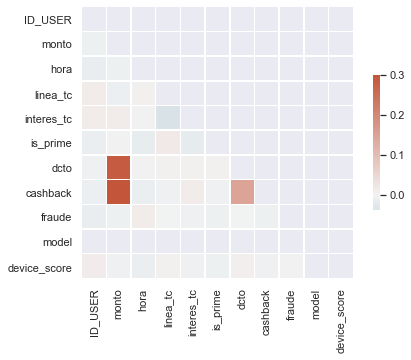

In [13]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:xlabel='hora', ylabel='Density'>

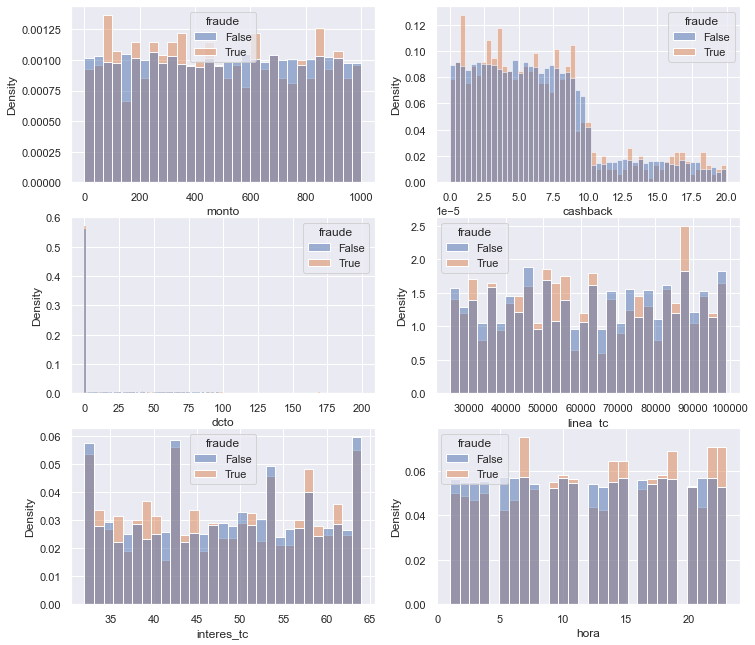

In [14]:
f, axes = plt.subplots(nrows=3, ncols=2,figsize=(12,11))

sns.histplot(data=df, x="monto", hue="fraude", stat="density", common_norm=False, ax = axes[0][0])
sns.histplot(data=df, x="cashback", hue="fraude", stat="density", common_norm=False, ax = axes[0][1])
sns.histplot(data=df, x="dcto", hue="fraude", stat="density", common_norm=False, ax = axes[1][0])
sns.histplot(data=df, x="linea_tc", hue="fraude", stat="density", common_norm=False, ax = axes[1][1])
sns.histplot(data=df, x="interes_tc", hue="fraude", stat="density", common_norm=False, ax = axes[2][0])
sns.histplot(data=df, x="hora", hue="fraude", stat="density", common_norm=False, ax = axes[2][1])

<AxesSubplot:xlabel='device_score', ylabel='proportion'>

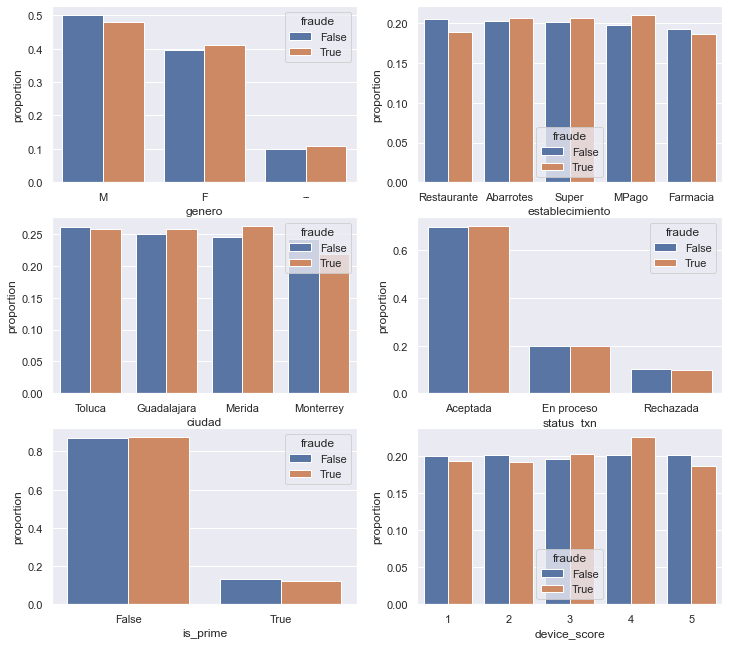

In [15]:
f, axes = plt.subplots(nrows=3, ncols=2,figsize=(12,11))

(df["genero"].groupby(df["fraude"]).value_counts(normalize=True).rename("proportion")
 .reset_index().pipe((sns.barplot, "data"), x="genero", y="proportion", hue="fraude",ax = axes[0,0]))
(df["establecimiento"].groupby(df["fraude"]).value_counts(normalize=True).rename("proportion")
 .reset_index().pipe((sns.barplot, "data"), x="establecimiento", y="proportion", hue="fraude",ax = axes[0,1]))
(df["ciudad"].groupby(df["fraude"]).value_counts(normalize=True).rename("proportion")
 .reset_index().pipe((sns.barplot, "data"), x="ciudad", y="proportion", hue="fraude",ax = axes[1,0]))
(df["status_txn"].groupby(df["fraude"]).value_counts(normalize=True).rename("proportion")
 .reset_index().pipe((sns.barplot, "data"), x="status_txn", y="proportion", hue="fraude",ax = axes[1,1]))
(df["is_prime"].groupby(df["fraude"]).value_counts(normalize=True).rename("proportion")
 .reset_index().pipe((sns.barplot, "data"), x="is_prime", y="proportion", hue="fraude",ax = axes[2,0]))
(df["device_score"].groupby(df["fraude"]).value_counts(normalize=True).rename("proportion")
 .reset_index().pipe((sns.barplot, "data"), x="device_score", y="proportion", hue="fraude",ax = axes[2,1]))

<AxesSubplot:xlabel='os', ylabel='proportion'>

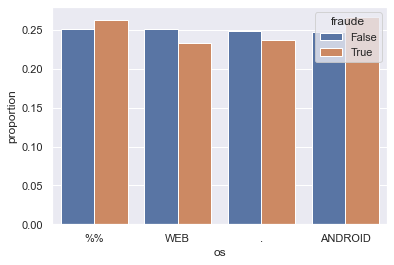

In [16]:
x, y, hue = "os", "proportion", "fraude"
hue_order = df['fraude'].unique()

(df[x]
 .groupby(df[hue])
 .value_counts(normalize=True)
 .rename(y)
 .reset_index()
 .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

## Análisis a nivel de transacción
Como se observó anteriormente, el dataset presenta cada dato a nivel de transacción, en donde hay usuarios con más de una trasancción, debido a esto es importante entender como se comporta las transacciones de nivel de sus variables y posteriormente hacer el mismo análisis a nivel de usuario. Para ello se procede a entender como se comportan las variables

In [17]:
#Variables numericas
df_fraude_grouped = df_fraude.groupby(['ID_USER']).agg({'monto':'mean','cashback':'mean',
                                                       'linea_tc':'mean','interes_tc':'mean',
                                                       'dcto':'mean'})
df_noFraude_grouped = df_noFraude.groupby(['ID_USER']).agg({'monto':'mean','cashback':'mean',
                                                           'linea_tc':'mean','interes_tc':'mean',
                                                            'dcto':'mean'})


mean_amount_fraud = np.mean(df_fraude_grouped['monto'])
mean_amount_nofraud =np.mean(df_noFraude_grouped['monto'])
print("Monto")
print("Promedio de monto en trasacciones fraudulentas: %.3f" % mean_amount_nofraud)
print("Promedio de monto en trasacciones no fraudulentas: %.3f" % mean_amount_fraud)

print("Cashback")
mean_cashback_fraud = np.mean(df_fraude_grouped['cashback'])
mean_cashback_nofraud =np.mean(df_noFraude_grouped['cashback'])
print("Promedio de cashback en trasacciones fraudulentas: %.3f" % mean_cashback_fraud)
print("Promedio de cashback en trasacciones no fraudulentas: %.3f" % mean_cashback_nofraud)

print("Línea TC")
mean_lineaTC_fraud = np.mean(df_fraude_grouped['linea_tc'])
mean_lineaTC_nofraud =np.mean(df_noFraude_grouped['linea_tc'])
print("Promedio de linea_tc en trasacciones fraudulentas: %.3f" % mean_lineaTC_fraud)
print("Promedio de linea_tc en trasacciones no fraudulentas: %.3f" % mean_lineaTC_nofraud)

print("Interés TC")
mean_interes_tc_fraud = np.mean(df_fraude_grouped['interes_tc'])
mean_interes_tc_nofraud =np.mean(df_noFraude_grouped['interes_tc'])
print("Promedio de interes_tc en trasacciones fraudulentas: %.3f" % mean_interes_tc_fraud)
print("Promedio de interes_tc en trasacciones no fraudulentas: %.3f" % mean_interes_tc_nofraud)

Monto
Promedio de monto en trasacciones fraudulentas: 496.196
Promedio de monto en trasacciones no fraudulentas: 493.438
Cashback
Promedio de cashback en trasacciones fraudulentas: 6.154
Promedio de cashback en trasacciones no fraudulentas: 6.222
Línea TC
Promedio de linea_tc en trasacciones fraudulentas: 61448.889
Promedio de linea_tc en trasacciones no fraudulentas: 62339.106
Interés TC
Promedio de interes_tc en trasacciones fraudulentas: 48.156
Promedio de interes_tc en trasacciones no fraudulentas: 48.158


## Analisis a nivel de usuario
Ahora se procede a revisar esta información a nivel de usuario, ya que es importante entender sí existe alguna característica evidente de las personas que tienen alguna transacción fraudulenta. Dentro del dataset, existen bastantes usuarios que tienen muchas transacción correctas y algunas fraudulentas, dado esto se define como usuario fraudulente aquel tenga al menos una transacción fraudulenta.

In [18]:
ids_fraude = df[df['fraude']==True][['ID_USER']].drop_duplicates()
ids_fraude['user_fraude'] = 1
ids_fraude.set_index('ID_USER',inplace=True)
df_p = df.set_index('ID_USER').join(ids_fraude)

df_fraude_grouped = df_p[df_p['user_fraude']==1].groupby(['ID_USER']).agg({'fecha':'count','monto':'mean','cashback':'mean',
                                                       'linea_tc':'mean','interes_tc':'mean',
                                                       'dcto':'mean'})
df_noFraude_grouped = df_p[df_p['user_fraude']!=1].groupby(['ID_USER']).agg({'fecha':'count','monto':'mean','cashback':'mean',
                                                       'linea_tc':'mean','interes_tc':'mean',
                                                       'dcto':'mean'})
print("Transacciones")
mean_trans_fraud = np.mean(df_fraude_grouped['fecha'])
mean_trans_nofraud =np.mean(df_noFraude_grouped['fecha'])
print("Promedio de transacciones personas que no hacen fraude: %.3f" % mean_trans_nofraud)
print("Promedio de transacciones personas que sí hacen fraude: %.3f" % mean_trans_fraud)

print("Monto")
mean_amount_fraud = np.mean(df_fraude_grouped['monto'])
mean_amount_nofraud =np.mean(df_noFraude_grouped['monto'])
print("Promedio de gasto promedio personas que no hacen fraude: %.3f" % mean_amount_nofraud)
print("Promedio de gasto promedio personas que sí hacen fraude: %.3f" % mean_amount_fraud)

print("Cashback")
mean_cashback_fraud = np.mean(df_fraude_grouped['cashback'])
mean_cashback_nofraud =np.mean(df_noFraude_grouped['cashback'])
print("Promedio de cashback personas que no hacen fraude: %.3f" % mean_cashback_fraud)
print("Promedio de cashback promedio personas que sí hacen fraude: %.3f" % mean_cashback_nofraud)


Transacciones
Promedio de transacciones personas que no hacen fraude: 5.769
Promedio de transacciones personas que sí hacen fraude: 11.544
Monto
Promedio de gasto promedio personas que no hacen fraude: 495.662
Promedio de gasto promedio personas que sí hacen fraude: 497.543
Cashback
Promedio de cashback personas que no hacen fraude: 6.231
Promedio de cashback promedio personas que sí hacen fraude: 6.203


Como se observa en los resultados anteriores, una diferencia notable entre estos dos grupos es que la cantidad de trasacciones promedio es mayor para las personas que cometen fraude, tenemos como ejemplo el siguiente caso:

In [19]:
df[df['ID_USER']==9][['ID_USER','fecha','fraude','monto']].sort_values(['fecha'])

,ID_USER,fecha,fraude,monto
36,9,2020-01-04,False,305.178078
41,9,2020-01-07,False,449.202371
43,9,2020-01-07,False,9.490080
37,9,2020-01-14,True,253.327147
38,9,2020-01-16,False,18.471148
39,9,2020-01-17,False,637.948552
42,9,2020-01-18,False,586.507627
35,9,2020-01-21,False,687.625262
44,9,2020-01-26,False,581.564202
40,9,2020-01-27,False,812.327552


Este usuario, posee 10 trasacciones en donde 1 de ella fue categorizada como fraudulenta, lo curioso es que el usuario sigue generando muchas más transacciones despues.

In [20]:
df['visita'] = 1
df['visita_acumulada'] = df.sort_values(['ID_USER','fecha','hora']).groupby(['ID_USER'])['visita'].cumsum()
##df['visitas_totales'] = df.sort_values(['ID_USER','fecha','hora']).groupby(['ID_USER'])['visita'].sum()
df.drop(['visita'], axis=1, inplace=True)

In [21]:
monto_fraude = np.sum(df[df['fraude']== True]['monto'])
print("Monto fraude: %.3f" % monto_fraude)

Monto fraude: 398600.730


<a id = 'Model'></a>
# <font color = "darkblue">Modelo</font>

Dado lo observado en la sección anterior, este apartado tiene como objetivo probar diferentes modelos para la detección de fraude. Para ello se utilizará como modelo base los árboles de decisión que han demostrado ser buenos para modelos desbalanceados y para detección de fraude.[1]

Para encontrar el mejor modelo se prueba diferentes métodos, se toman los resultados y se analiza que modelo fue el que tuvo el mejor rendimiendo. Los métodos utilizados fueron los siguientes:
* Árbol de decisión
* Árbol de decisión con sobre muestreo
* Árbol de decisión SMOTE
* Árbol de decisión con costos asociados de clasificación

Adicionalmente, por cada modelo se generan subsets de entrenamiento y test, utilizando la proporción 0.75 y 0.25 respectivamente. Por otro lado, se utilizan como métricas de medición matriz de confución, F-score y sensibilidad.

<a id = 'model1'></a>
## <font color = "darkblue">1er aproach (Árbol de decisión)</font>


Para este primer modelo se quiso probar que resultados se obtienen con la data original, para ello se separan las variables numericas de las categoricas y se obtienen los resultados del modelo. Posteriormente, se utilizan árboles de decisión para detectar que variables son las más representativas para la clasificación, luego se retiran y se vuelve a probar el modelo

In [35]:
df_clasificar = pd.DataFrame(df, columns=df.columns)
col_names = df.columns
feature_cols = [ 'genero', 'monto', 'fecha', 'hora',
       'establecimiento', 'ciudad', 'tipo_tc', 'linea_tc', 'interes_tc',
       'status_txn', 'is_prime', 'dcto', 'cashback','device_score', 'os']

X = df_clasificar[feature_cols]
y = df_clasificar['fraude']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25)



In [36]:
# Parte númerica
numeric_features = ['monto', 'hora', 'linea_tc','interes_tc','dcto','cashback']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), #Retira los nulos y los reemplza por la mediana
])

# Parte categórica
categorical_features = ['genero', 'fecha', 'establecimiento', 'ciudad','tipo_tc','status_txn','is_prime', 'os','device_score']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='faltante')),#Retira los nulos y los reemplza por la categoría 'faltante'
    ('ordinal', OrdinalEncoder()) #Encoding de las variables categoricas
])

# Se crea un objeto preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [37]:
# Árbol de decisón
clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', tree.DecisionTreeClassifier())
                        ])
clf = clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
print('Decision Tree')
F_score_11, acc_11 = display_summary(y_test,y_pred_tree)


scores_11 = cross_val_score(clf, df[feature_cols], df['fraude'], cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_11.mean(), scores_11.std() * 2))


Decision Tree
confusion matrix
[[   8  271]
 [ 212 6253]]
sensitivity is %f 0.03636363636363636
specificity is %f 0.9584610668301655
accuracy is %f 0.9283807829181495
balanced accuracy is % 0.49741235159690095
F-score is % 0.03206412825651302
Accuracy: 0.93 (+/- 0.00)


#### Selección de Variables

In [38]:
df_prep = pd.DataFrame(preprocessor.fit_transform(X_train[feature_cols]), 
                       columns=['monto', 'hora', 'linea_tc','interes_tc','dcto',
                                'cashback','device_score','genero', 'fecha', 
                                'establecimiento', 'ciudad','tipo_tc','status_txn',
                                'is_prime', 'os'])
#Se crea un modelo de arbol que se utilizará para hallar las variables
reg = ExtraTreesClassifier(n_estimators=50) 
reg.fit(df_prep, y_train) #Entrenamiento

imp = reg.feature_importances_ #Se guardan las importancias de cada variable al modelo
mean = np.mean(imp)
bool_array = imp >= mean #Vector booleano para saber que importancias están por encima de la media
indices = [] #Vector de indicación de variables importantes
indices2 = [] #Vector de indicación de variables no importantes
H = 0 
H2 = 0

# Ciclo que busca las variables más representativas y almacena sus indices 
for q in range(len(bool_array)):
    if ~bool_array[q]:
        indices.append(H)
    H = H+1 
# Ciclo que busca las variables menos representativas y almacena sus indices 
for w in range(len(bool_array)):
    if bool_array[w]:
        indices2.append(H2)
    H2 = H2+1

columnas_eliminar = [] # Vector que almacena el nombre de las variables menos representativas
columnas_restantes = [] # Vector que almacena el nombre de las variables más representativas
for ind in indices:
    columnas_eliminar.append(df_prep.columns[ind])
for ind in indices2:
    columnas_restantes.append(df_prep.columns[ind])
    
print('columnas a eliminar:', columnas_eliminar)
print('columnas que se mantienen:',columnas_restantes)

columnas a eliminar: ['dcto', 'device_score', 'fecha', 'establecimiento', 'ciudad', 'tipo_tc', 'status_txn', 'is_prime', 'os']
columnas que se mantienen: ['monto', 'hora', 'linea_tc', 'interes_tc', 'cashback', 'genero']


In [41]:
col_names = df.columns
feature_cols = [ 'monto', 'hora',   'linea_tc', 'interes_tc',
                'cashback','fecha']

X = df_clasificar[feature_cols]
y = df_clasificar['fraude']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25)

In [42]:
# Parte númerica
numeric_features = ['monto', 'hora', 'linea_tc','interes_tc','cashback']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), #Retira los nulos y los reemplza por la mediana
])

# Parte categórica
categorical_features = [ 'fecha']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='faltante')),#Retira los nulos y los reemplza por la categoría 'faltante'
    ('ordinal', OrdinalEncoder()) #Encoding de las variables categoricas
])

# Se crea un objeto preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Árbol de decisón
clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', tree.DecisionTreeClassifier())
                        ])
clf = clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
F_score_12, acc_12 = display_summary(y_test,y_pred_tree)


scores_12 = cross_val_score(clf, df[feature_cols], df['fraude'], cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_12.mean(), scores_12.std() * 2))



confusion matrix
[[   6  266]
 [ 181 6291]]
sensitivity is %f 0.03208556149732621
specificity is %f 0.9594326673783743
accuracy is %f 0.9337188612099644
balanced accuracy is % 0.49575911443785026
F-score is % 0.026143790849673203
Accuracy: 0.93 (+/- 0.01)


<a id = 'model2'></a>
# <font color = "darkblue">2do aproach (Sobre muestreo + Sub muestreo)</font>


Para el segundo modelo se quiso arreglar el desbalance que existe en las categorías a clasificar, para ello se utilizó la librería de SciKit Learn Sample, y se sobre muestro la clase minoritaria con reemplazo y se sub muestro la clase mayoritaria sin reemplazo.  

In [44]:
df_clasificar = pd.DataFrame(resample(df[df['fraude']==True], n_samples=3000, replace = True),columns = df.columns)

#Sobremuestreo; se van sobremuestrear 20.000 datos para balancear la información
df_clasificar = df_clasificar.append(pd.DataFrame(resample(df[df['fraude']==False], n_samples=5000, replace = True)))
print('Tamaño dataset sampleado %s' % Counter(df_clasificar['fraude']))

Tamaño dataset sampleado Counter({False: 5000, True: 3000})


In [45]:
col_names = df.columns
feature_cols = [ 'genero', 'monto', 'fecha', 'hora',
       'establecimiento', 'ciudad', 'tipo_tc', 'linea_tc', 'interes_tc',
       'status_txn', 'is_prime', 'dcto', 'cashback','device_score', 'os']

X = df_clasificar[feature_cols]
y = df_clasificar['fraude']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25)

In [46]:
# Parte númerica
numeric_features = ['monto', 'hora', 'linea_tc','interes_tc','dcto','cashback']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), #Retira los nulos y los reemplza por la mediana
])

# Parte categórica
categorical_features = ['genero', 'fecha', 'establecimiento', 'ciudad','tipo_tc','status_txn','is_prime', 'os','device_score']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='faltante')),#Retira los nulos y los reemplza por la categoría 'faltante'
    ('ordinal', OrdinalEncoder()) #Encoding de las variables categoricas
])

# Se crea un objeto preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Árbol de decisón
clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', tree.DecisionTreeClassifier())
                        ])
clf = clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
print('Decision Tree')
F_score_21, acc_21 = display_summary(y_test,y_pred_tree)


scores_21 = cross_val_score(clf, df[feature_cols], df['fraude'], cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_21.mean(), scores_21.std() * 2))


Decision Tree
confusion matrix
[[ 718  183]
 [  46 1053]]
sensitivity is %f 0.9397905759162304
specificity is %f 0.8519417475728155
accuracy is %f 0.8855
balanced accuracy is % 0.8958661617445229
F-score is % 0.8624624624624625
Accuracy: 0.93 (+/- 0.00)


#### Selección de Variables

In [47]:
df_prep = pd.DataFrame(preprocessor.fit_transform(X_train[feature_cols]), 
                       columns=['monto', 'hora', 'linea_tc','interes_tc',
                                'dcto','cashback','device_score','genero', 
                                'fecha', 'establecimiento', 'ciudad','tipo_tc',
                                'status_txn','is_prime', 'os'])
#Se crea un modelo de arbol que se utilizará para hallar las variables
reg = ExtraTreesClassifier(n_estimators=50) 
reg.fit(df_prep, y_train) #Entrenamiento

imp = reg.feature_importances_ #Se guardan las importancias de cada variable al modelo
mean = np.mean(imp)
bool_array = imp >= mean #Vector booleano para saber que importancias están por encima de la media
indices = [] #Vector de indicación de variables importantes
indices2 = [] #Vector de indicación de variables no importantes
H = 0 
H2 = 0

# Ciclo que busca las variables más representativas y almacena sus indices 
for q in range(len(bool_array)):
    if ~bool_array[q]:
        indices.append(H)
    H = H+1 
# Ciclo que busca las variables menos representativas y almacena sus indices 
for w in range(len(bool_array)):
    if bool_array[w]:
        indices2.append(H2)
    H2 = H2+1

columnas_eliminar = [] # Vector que almacena el nombre de las variables menos representativas
columnas_restantes = [] # Vector que almacena el nombre de las variables más representativas
for ind in indices:
    columnas_eliminar.append(df_prep.columns[ind])
for ind in indices2:
    columnas_restantes.append(df_prep.columns[ind])
    
    
print('columnas a eliminar:', columnas_eliminar)
print('columnas que se mantienen:',columnas_restantes)

columnas a eliminar: ['dcto', 'device_score', 'establecimiento', 'ciudad', 'tipo_tc', 'status_txn', 'is_prime']
columnas que se mantienen: ['monto', 'hora', 'linea_tc', 'interes_tc', 'cashback', 'genero', 'fecha', 'os']


In [49]:
col_names = df.columns
feature_cols = ['monto', 'fecha', 'hora', 'linea_tc', 'interes_tc',
                'cashback','genero',  'os']

X = df_clasificar[feature_cols]
y = df_clasificar['fraude']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25)

In [52]:
# Parte númerica
numeric_features = ['monto', 'hora', 'linea_tc','interes_tc','cashback']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), #Retira los nulos y los reemplza por la mediana
])

# Parte categórica
categorical_features = [ 'fecha', 'genero','os']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='faltante')),#Retira los nulos y los reemplza por la categoría 'faltante'
    ('ordinal', OrdinalEncoder()) #Encoding de las variables categoricas
])

# Se crea un objeto preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Árbol de decisón
clf = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', tree.DecisionTreeClassifier())
                        ])
clf = clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
print('Decision Tree')
F_score_22, acc_22 = display_summary(y_test,y_pred_tree)


scores_22 = cross_val_score(clf, df[feature_cols], df['fraude'], cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores_22.mean(), scores_22.std() * 2))



Decision Tree
confusion matrix
[[ 718  210]
 [  41 1031]]
sensitivity is %f 0.9459815546772069
specificity is %f 0.830781627719581
accuracy is %f 0.8745
balanced accuracy is % 0.8883815911983939
F-score is % 0.8512151748666271
Accuracy: 0.93 (+/- 0.01)



<a id = 'model3'></a>
# <font color = "darkblue"> 3er aproach (SMOTE)</font>

Para este ejercicio, se quiso probar una forma distinta de muestreo de la clase minoritaria, la técnica SMOTE es muy útil cuando la clase minoritaria es considerablemente menor [2]

In [53]:
# Parte númerica
numeric_features = ['monto', 'hora', 'linea_tc','interes_tc','dcto','cashback']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), #Retira los nulos y los reemplza por la mediana
])

# Parte categórica
categorical_features = ['genero', 'fecha', 'establecimiento', 'ciudad','tipo_tc','status_txn','is_prime',
                        'model', 'os','device_score']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='faltante')),#Retira los nulos y los reemplza por la categoría 'faltante'
    ('ordinal', OrdinalEncoder()) #Encoding de las variables categoricas
])

# Se crea un objeto preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


feature_cols = [ 'genero', 'monto', 'fecha', 'hora',
       'establecimiento', 'ciudad', 'tipo_tc', 'linea_tc', 'interes_tc',
       'status_txn', 'is_prime', 'dcto', 'cashback', 'model','device_score', 'os']
df_clasificar = pd.DataFrame(df, columns=df.columns)
df_prep = pd.DataFrame(preprocessor.fit_transform(df_clasificar[feature_cols]), 
                       columns=['monto', 'hora', 'linea_tc','interes_tc',
                                        'dcto','cashback','device_score','genero', 
                                        'fecha','establecimiento', 'ciudad','tipo_tc',
                                        'status_txn','is_prime','model', 'os'])

X = df_prep[feature_cols]
y = df['fraude']

# Apply the SMOTE over−sampling 
sm = SMOTE(sampling_strategy='auto' )
X_resampled, y_resampled = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_resampled))

Resampled dataset shape Counter({False: 26165, True: 26165})


In [54]:
X = X_resampled
y = y_resampled
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25)

# Árbol de decisón
clf = Pipeline(steps=[
                        ('classifier', tree.DecisionTreeClassifier())
                        ])
clf = clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
print('Decision Tree')
F_score_31, acc_31 = display_summary(y_test,y_pred_tree)


Decision Tree
confusion matrix
[[6209  288]
 [ 243 6343]]
sensitivity is %f 0.9623372597644141
specificity is %f 0.9565676368571859
accuracy is %f 0.959412978674616
balanced accuracy is % 0.9594524483108
F-score is % 0.9589929724303033


#### Selección de Variables

In [55]:

#Se crea un modelo de arbol que se utilizará para hallar las variables
reg = ExtraTreesClassifier(n_estimators=50) 
reg.fit(X_resampled, y_resampled) #Entrenamiento

imp = reg.feature_importances_ #Se guardan las importancias de cada variable al modelo
mean = np.mean(imp)
bool_array = imp >= mean #Vector booleano para saber que importancias están por encima de la media
indices = [] #Vector de indicación de variables importantes
indices2 = [] #Vector de indicación de variables no importantes
H = 0 
H2 = 0

# Ciclo que busca las variables más representativas y almacena sus indices 
for q in range(len(bool_array)):
    if ~bool_array[q]:
        indices.append(H)
    H = H+1 
# Ciclo que busca las variables menos representativas y almacena sus indices 
for w in range(len(bool_array)):
    if bool_array[w]:
        indices2.append(H2)
    H2 = H2+1

columnas_eliminar = [] # Vector que almacena el nombre de las variables menos representativas
columnas_restantes = [] # Vector que almacena el nombre de las variables más representativas
for ind in indices:
    columnas_eliminar.append(df_prep.columns[ind])
for ind in indices2:
    columnas_restantes.append(df_prep.columns[ind])
    
        
print('columnas a eliminar:', columnas_eliminar)
print('columnas que se mantienen:',columnas_restantes)

columnas a eliminar: ['monto', 'hora', 'interes_tc', 'genero', 'fecha', 'establecimiento', 'ciudad', 'tipo_tc', 'status_txn']
columnas que se mantienen: ['linea_tc', 'dcto', 'cashback', 'device_score', 'is_prime', 'model', 'os']


In [56]:
# Árbol de decisón
clf = Pipeline(steps=[
                        ('classifier', tree.DecisionTreeClassifier())
                        ])
clf = clf.fit(X_train[columnas_restantes], y_train)
y_pred_tree = clf.predict(X_test[columnas_restantes])
print('Decision Tree')
F_score_32, acc_32 = display_summary(y_test,y_pred_tree)


Decision Tree
confusion matrix
[[6236  250]
 [ 216 6381]]
sensitivity is %f 0.9665220086794792
specificity is %f 0.9622982958829739
accuracy is %f 0.964381258121226
balanced accuracy is % 0.9644101522812265
F-score is % 0.9639820683258618



<a id = 'model3'></a>
# <font color = "darkblue"> 4to Aproach (Modelo sensible al costo)</font>

Con base al paper "Fraud Detection by Stacking Cost-Sensitive Decision Trees" se quiso tomar un enfoque distinto y llevar el problema a un enfoque más orientado a la realidad del problema. En este texto se describe como los modelos de fraude que tienen en cuentas los costos reales de clasificar mal o bien pueden afectar el resultado del modelo. 

In [57]:
from metrics import cost_loss, savings_score
from models import  CostSensitiveDecisionTreeClassifier #Librearias tomadas de 

In [58]:
df_clasificar = df

col_names = df.columns
feature_cols = [ 'genero', 'monto', 'fecha', 'hora',
       'establecimiento', 'ciudad', 'tipo_tc', 'linea_tc', 'interes_tc',
       'status_txn', 'is_prime', 'dcto', 'cashback', 'model','device_score', 'os']

X = df_clasificar[feature_cols]
y = df_clasificar['fraude']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25)

In [59]:
cost_mat_train = np.zeros((len(y_train),4))
#false positives cost 5
cost_mat_train[:,0]=10
#false negatives costthe transaction amount
cost_mat_train[:,1]=X_train['monto']
#true positives also cost 5
cost_mat_train[:,2]=10
 
cost_mat_test = np.zeros((len(y_test),4))
cost_mat_test[:,0]=10
cost_mat_test[:,1]=X_test['monto']
cost_mat_test[:,2]=10

In [60]:

h = CostSensitiveDecisionTreeClassifier()
h.fit(np.array(preprocessor.fit_transform(X_train[feature_cols])), np.array(y_train), cost_mat_train)
y_pred_tree_cslr = h.predict(np.array(preprocessor.fit_transform(X_test[feature_cols])))

print('decision tree: cost sensitve learning')
print(cost_loss(y_test,y_pred_tree_cslr,cost_mat_test))

print('Decision Tree')
F_score_41, acc_41 = display_summary(y_test,y_pred_tree_cslr)

decision tree: cost sensitve learning
60660.925577132846
Decision Tree
confusion matrix
[[ 135 4211]
 [  73 2325]]
sensitivity is %f 0.6490384615384616
specificity is %f 0.3557221542227662
accuracy is %f 0.36476868327402134
balanced accuracy is % 0.5023803078806139
F-score is % 0.05928853754940712


# Resultados

In [61]:
df_resultados = pd.DataFrame(np.array([['1.1 Árbol de decisión', F_score_11, acc_11],
                                      ['1.2 Árbol de decisión (selección de variables)', F_score_12, acc_12],
                                      ['2.1 Árbol de decisión muestreado', F_score_21, acc_21],
                                      ['2.2 Árbol de decisión muestreado (selección de variables)', F_score_22, acc_22],
                                      ['3.1 Árbol de decisión SMOTE', F_score_31, acc_31],
                                      ['3.2 Árbol de decisión SMOTE (selección de variables)', F_score_32, acc_32],
                                      ['4.1 Árbol de decisión Costos', F_score_41, acc_41],
                                      #['3.2 Árbol de decisión Costos (selección de variables)', F_score_42, acc_42]
                                      ]), 
                            columns= ['Modelo', 'F-Score','Balanced Acc'])
df_resultados

,Modelo,F-Score,Balanced Acc
0,1.1 Árbol de decisión,0.03206412825651302,0.49741235159690095
1,1.2 Árbol de decisión (selección de variables),0.026143790849673203,0.49575911443785026
2,2.1 Árbol de decisión muestreado,0.8624624624624625,0.8958661617445229
3,2.2 Árbol de decisión muestreado (selección de...,0.8512151748666271,0.8883815911983939
4,3.1 Árbol de decisión SMOTE,0.9589929724303033,0.9594524483108
5,3.2 Árbol de decisión SMOTE (selección de vari...,0.9639820683258618,0.9644101522812265
6,4.1 Árbol de decisión Costos,0.05928853754940712,0.5023803078806139
